In [16]:
import os
import subprocess
import sys
import json
import requests
import re
from getpass import getpass
from datetime import datetime
from typing import Dict, List, Union
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [17]:
def install_packages():
    """Install required packages"""
    packages = [
        'fetch-my-weather',
        'hands-on-ai',
        'matplotlib',
        'numpy'
    ]

    for package in packages:
        try:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✓ {package} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to install {package}: {e}")
            return False
    return True

In [18]:
def setup_environment():
    """Set up environment variables"""
    print("\n=== Setting up environment ===")

    # Set server URL
    server_url = 'https://ollama.serveur.au'
    os.environ['HANDS_ON_AI_SERVER'] = server_url
    print(f"✓ Server URL set: {server_url}")

    # Set model
    model = 'granite3.2'
    os.environ['HANDS_ON_AI_MODEL'] = model
    print(f"✓ Model set: {model}")

    # Set API key directly
    api_key = 'student-api-key-123'
    os.environ['HANDS_ON_AI_API_KEY'] = api_key
    print("✓ API key set successfully")
    return True

In [19]:
def get_weather_data(location: str, forecast_days: int = 5) -> Dict:
    """
    Retrieve weather data for a specified location with multiple API fallbacks.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    if not location or not isinstance(location, str):
        raise ValueError("Location must be a non-empty string")

    if not isinstance(forecast_days, int) or forecast_days < 1 or forecast_days > 5:
        raise ValueError("Forecast days must be an integer between 1 and 5")

    location = location.strip()

    # Try multiple weather APIs with different timeouts
    apis_to_try = [
        {
            'name': 'wttr.in',
            'url': f"https://wttr.in/{location}?format=j1",
            'timeout': 15
        },
        {
            'name': 'wttr.in_simple',
            'url': f"http://wttr.in/{location}?format=j1",
            'timeout': 20
        }
    ]

    for api in apis_to_try:
        try:
            print(f"   Trying {api['name']} API...")

            # Configure session for better reliability
            session = requests.Session()
            session.headers.update({
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            })

            response = session.get(api['url'], timeout=api['timeout'])
            response.raise_for_status()

            data = response.json()

            if 'current_condition' not in data or 'weather' not in data:
                print(f"   {api['name']} returned invalid data, trying next...")
                continue

            if not data['current_condition'] or not data['weather']:
                print(f"   {api['name']} returned empty data, trying next...")
                continue

            print(f"   ✓ {api['name']} API successful!")

            current = data['current_condition'][0]
            forecast = data['weather'][:forecast_days]

            weather_data = {
                'location': location,
                'current': {
                    'temperature': int(current['temp_C']),
                    'temperature_f': int(current['temp_F']),
                    'condition': current['weatherDesc'][0]['value'],
                    'humidity': int(current['humidity']),
                    'wind_speed': int(current['windspeedKmph']),
                    'wind_direction': current['winddir16Point'],
                    'visibility': int(current['visibility']),
                    'pressure': int(current['pressure']),
                    'feels_like': int(current['FeelsLikeC']),
                    'feels_like_f': int(current['FeelsLikeF']),
                    'uv_index': int(current['uvIndex'])
                },
                'forecast': []
            }

            for day in forecast:
                day_data = {
                    'date': day['date'],
                    'max_temp': int(day['maxtempC']),
                    'min_temp': int(day['mintempC']),
                    'max_temp_f': int(day['maxtempF']),
                    'min_temp_f': int(day['mintempF']),
                    'condition': day['hourly'][0]['weatherDesc'][0]['value'],
                    'humidity': int(day['hourly'][0]['humidity']),
                    'wind_speed': int(day['hourly'][0]['windspeedKmph']),
                    'wind_direction': day['hourly'][0]['winddir16Point'],
                    'precipitation': float(day['hourly'][0].get('precipMM', 0))
                }
                weather_data['forecast'].append(day_data)

            weather_data['timestamp'] = datetime.now().isoformat()
            weather_data['forecast_days'] = len(weather_data['forecast'])
            weather_data['api_used'] = api['name']

            return weather_data

        except requests.exceptions.Timeout:
            print(f"   ⏰ {api['name']} timed out, trying next API...")
            continue
        except requests.exceptions.ConnectionError:
            print(f"   🔌 {api['name']} connection failed, trying next API...")
            continue
        except requests.exceptions.HTTPError as e:
            print(f"   ❌ {api['name']} HTTP error: {e}, trying next API...")
            continue
        except Exception as e:
            print(f"   ❌ {api['name']} error: {e}, trying next API...")
            continue

    # If all APIs fail, return a mock response so the chatbot can still demonstrate
    print("   ⚠️ All weather APIs failed, generating demo data...")
    return create_demo_weather_data(location, forecast_days)

In [20]:
def create_demo_weather_data(location: str, forecast_days: int) -> Dict:
    """
    Create demo weather data when APIs are unavailable.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast

    Returns:
        dict: Demo weather data
    """
    import random
    from datetime import datetime, timedelta

    # Generate realistic demo data based on location
    base_temp = 20  # Default temperature
    if location.lower() in ['perth', 'sydney', 'melbourne', 'brisbane', 'australia']:
        base_temp = 22
    elif location.lower() in ['london', 'paris', 'berlin', 'moscow']:
        base_temp = 12
    elif location.lower() in ['tokyo', 'seoul', 'beijing']:
        base_temp = 18
    elif location.lower() in ['new york', 'chicago', 'toronto']:
        base_temp = 15

    conditions = ['Sunny', 'Partly cloudy', 'Cloudy', 'Light rain', 'Clear']

    current_temp = base_temp + random.randint(-5, 5)

    weather_data = {
        'location': location,
        'current': {
            'temperature': current_temp,
            'temperature_f': int(current_temp * 9/5 + 32),
            'condition': random.choice(conditions),
            'humidity': random.randint(40, 80),
            'wind_speed': random.randint(5, 25),
            'wind_direction': random.choice(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']),
            'visibility': random.randint(8, 15),
            'pressure': random.randint(1000, 1020),
            'feels_like': current_temp + random.randint(-3, 3),
            'feels_like_f': int((current_temp + random.randint(-3, 3)) * 9/5 + 32),
            'uv_index': random.randint(1, 8)
        },
        'forecast': []
    }

    # Generate forecast data
    today = datetime.now()
    for i in range(forecast_days):
        forecast_date = today + timedelta(days=i)
        day_temp_variation = random.randint(-3, 3)
        max_temp = base_temp + day_temp_variation + random.randint(2, 8)
        min_temp = base_temp + day_temp_variation - random.randint(2, 8)

        day_data = {
            'date': forecast_date.strftime('%Y-%m-%d'),
            'max_temp': max_temp,
            'min_temp': min_temp,
            'max_temp_f': int(max_temp * 9/5 + 32),
            'min_temp_f': int(min_temp * 9/5 + 32),
            'condition': random.choice(conditions),
            'humidity': random.randint(40, 80),
            'wind_speed': random.randint(5, 25),
            'wind_direction': random.choice(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']),
            'precipitation': random.choice([0, 0, 0, 0.5, 1.2, 2.5])  # Mostly dry with some rain
        }
        weather_data['forecast'].append(day_data)

    weather_data['timestamp'] = datetime.now().isoformat()
    weather_data['forecast_days'] = len(weather_data['forecast'])
    weather_data['api_used'] = 'demo_data'

    return weather_data
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    question_lower = question.lower()

    # Extract location patterns
    location_patterns = [
        r'weather in (.+?)(?:\s|$|[,\.])',
        r'weather for (.+?)(?:\s|$|[,\.])',
        r'temperature in (.+?)(?:\s|$|[,\.])',
        r'forecast for (.+?)(?:\s|$|[,\.])',
        r'(?:in|at|for)\s+([A-Za-z\s]+?)(?:\s+weather|\s+temperature|\?|$)'
    ]

    location = None
    for pattern in location_patterns:
        match = re.search(pattern, question_lower)
        if match:
            location = match.group(1).strip()
            break

    # Time period detection
    time_period = 'current'
    forecast_days = 1

    if any(word in question_lower for word in ['forecast', 'week', 'days', 'tomorrow']):
        time_period = 'forecast'
        forecast_days = 5

    if 'tomorrow' in question_lower:
        forecast_days = 2
    elif any(word in question_lower for word in ['3 day', 'three day']):
        forecast_days = 3

    # Weather attribute detection
    attribute = 'general'
    if any(word in question_lower for word in ['temperature', 'temp', 'hot', 'cold']):
        attribute = 'temperature'
    elif any(word in question_lower for word in ['rain', 'precipitation', 'shower']):
        attribute = 'precipitation'
    elif any(word in question_lower for word in ['wind', 'windy']):
        attribute = 'wind'
    elif any(word in question_lower for word in ['humidity', 'humid']):
        attribute = 'humidity'

    return {
        'location': location,
        'time_period': time_period,
        'forecast_days': forecast_days,
        'attribute': attribute,
        'original_question': question
    }

In [21]:
def create_temperature_visualisation(weather_data: Dict, output_type: str = 'display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation
    """
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        fig, ax = plt.subplots(figsize=(12, 6))

        # Prepare data
        dates = []
        max_temps = []
        min_temps = []

        # Add current temperature as first point
        today = datetime.now()
        dates.append(today.strftime('%Y-%m-%d'))
        current_temp = weather_data['current']['temperature']
        max_temps.append(current_temp)
        min_temps.append(current_temp)

        # Add forecast data
        for day in weather_data['forecast'][1:]:  # Skip today if it's in forecast
            dates.append(day['date'])
            max_temps.append(day['max_temp'])
            min_temps.append(day['min_temp'])

        x_pos = range(len(dates))

        # Create the plot
        ax.plot(x_pos, max_temps, 'ro-', label='Max Temperature', linewidth=2, markersize=6)
        ax.plot(x_pos, min_temps, 'bo-', label='Min Temperature', linewidth=2, markersize=6)
        ax.fill_between(x_pos, max_temps, min_temps, alpha=0.3, color='lightblue')

        # Customize the plot
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Temperature (°C)', fontsize=12)
        ax.set_title(f'Temperature Forecast for {weather_data["location"]}', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Format x-axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels([d[-5:] for d in dates], rotation=45)

        # Add temperature labels on points
        for i, (max_t, min_t) in enumerate(zip(max_temps, min_temps)):
            ax.annotate(f'{max_t}°', (i, max_t), textcoords="offset points", xytext=(0,10), ha='center')
            ax.annotate(f'{min_t}°', (i, min_t), textcoords="offset points", xytext=(0,-15), ha='center')

        plt.tight_layout()

        if output_type == 'figure':
            return fig
        else:
            plt.show()
            return None

    except Exception as e:
        print(f"Error creating temperature visualization: {e}")
        return None

In [22]:
def create_precipitation_visualisation(weather_data: Dict, output_type: str = 'display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation
    """
    try:
        import matplotlib.pyplot as plt
        import numpy as np

        fig, ax = plt.subplots(figsize=(10, 6))

        # Prepare data
        dates = []
        precipitation = []

        for day in weather_data['forecast']:
            dates.append(day['date'])
            precipitation.append(day.get('precipitation', 0))

        x_pos = range(len(dates))

        # Create bar chart
        bars = ax.bar(x_pos, precipitation, color='lightblue', edgecolor='darkblue', linewidth=1.2)

        # Customize the plot
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Precipitation (mm)', fontsize=12)
        ax.set_title(f'Precipitation Forecast for {weather_data["location"]}', fontsize=14, fontweight='bold')
        ax.grid(True, axis='y', alpha=0.3)

        # Format x-axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels([d[-5:] for d in dates], rotation=45)

        # Add value labels on bars
        for bar, precip in zip(bars, precipitation):
            if precip > 0:
                ax.annotate(f'{precip:.1f}mm',
                           (bar.get_x() + bar.get_width()/2, bar.get_height()),
                           textcoords="offset points", xytext=(0,3), ha='center')

        plt.tight_layout()

        if output_type == 'figure':
            return fig
        else:
            plt.show()
            return None

    except Exception as e:
        print(f"Error creating precipitation visualization: {e}")
        return None

In [23]:
def generate_weather_response(parsed_question: Dict, weather_data: Dict) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    location = weather_data['location']
    current = weather_data['current']

    if parsed_question['attribute'] == 'temperature':
        response = f"🌡️ The current temperature in {location} is {current['temperature']}°C ({current['temperature_f']}°F), feeling like {current['feels_like']}°C."

        if parsed_question['time_period'] == 'forecast' and weather_data['forecast']:
            tomorrow = weather_data['forecast'][1] if len(weather_data['forecast']) > 1 else weather_data['forecast'][0]
            response += f" Tomorrow's high will be {tomorrow['max_temp']}°C with a low of {tomorrow['min_temp']}°C."

    elif parsed_question['attribute'] == 'precipitation':
        response = f"🌧️ Weather conditions in {location}: {current['condition']}."
        if weather_data['forecast']:
            rain_days = [day for day in weather_data['forecast'] if day.get('precipitation', 0) > 0]
            if rain_days:
                response += f" Rain is expected on {len(rain_days)} of the next {len(weather_data['forecast'])} days."
            else:
                response += " No precipitation expected in the forecast."

    else:
        response = f"🌤️ Current weather in {location}: {current['condition']}, {current['temperature']}°C"
        response += f" with {current['humidity']}% humidity and {current['wind_speed']} km/h winds from the {current['wind_direction']}."

        if parsed_question['time_period'] == 'forecast' and weather_data['forecast']:
            response += f"\n\n📅 {len(weather_data['forecast'])}-day forecast:"
            for i, day in enumerate(weather_data['forecast'][:3]):
                day_name = "Today" if i == 0 else "Tomorrow" if i == 1 else day['date'][-5:]
                response += f"\n• {day_name}: {day['condition']}, High {day['max_temp']}°C / Low {day['min_temp']}°C"

    return response

In [24]:
def parse_weather_question(question: str) -> Dict:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    question_lower = question.lower()

    # Extract location patterns
    location_patterns = [
        r'weather in (.+?)(?:\s|$|[,\.])',
        r'weather for (.+?)(?:\s|$|[,\.])',
        r'temperature in (.+?)(?:\s|$|[,\.])',
        r'forecast for (.+?)(?:\s|$|[,\.])',
        r'(?:in|at|for)\s+([A-Za-z\s]+?)(?:\s+weather|\s+temperature|\?|$)'
    ]

    location = None
    for pattern in location_patterns:
        match = re.search(pattern, question_lower)
        if match:
            location = match.group(1).strip()
            break

    # Time period detection
    time_period = 'current'
    forecast_days = 1

    if any(word in question_lower for word in ['forecast', 'week', 'days', 'tomorrow']):
        time_period = 'forecast'
        forecast_days = 5

    if 'tomorrow' in question_lower:
        forecast_days = 2
    elif any(word in question_lower for word in ['3 day', 'three day']):
        forecast_days = 3

    # Weather attribute detection
    attribute = 'general'
    if any(word in question_lower for word in ['temperature', 'temp', 'hot', 'cold']):
        attribute = 'temperature'
    elif any(word in question_lower for word in ['rain', 'precipitation', 'shower']):
        attribute = 'precipitation'
    elif any(word in question_lower for word in ['wind', 'windy']):
        attribute = 'wind'
    elif any(word in question_lower for word in ['humidity', 'humid']):
        attribute = 'humidity'

    return {
        'location': location,
        'time_period': time_period,
        'forecast_days': forecast_days,
        'attribute': attribute,
        'original_question': question
    }

In [25]:
def is_weather_question(question: str) -> bool:
    """Check if the question is weather-related"""
    weather_keywords = [
        'weather', 'temperature', 'temp', 'forecast', 'rain', 'sunny', 'cloudy',
        'wind', 'humidity', 'precipitation', 'hot', 'cold', 'warm', 'cool'
    ]
    return any(keyword in question.lower() for keyword in weather_keywords)

def handle_weather_query(question: str) -> str:
    """Handle weather-related queries"""
    try:
        parsed = parse_weather_question(question)

        if not parsed['location']:
            return "🌍 I'd be happy to help with weather information! Could you please specify a location? For example: 'What's the weather in Perth?'"

        print(f"🔍 Getting weather data for {parsed['location']}...")
        weather_data = get_weather_data(parsed['location'], parsed['forecast_days'])

        response = generate_weather_response(parsed, weather_data)

        # Add note if using demo data
        if weather_data.get('api_used') == 'demo_data':
            response += "\n\n📝 Note: Weather APIs are currently unavailable, showing demo data for demonstration purposes."

        # Create visualizations if appropriate
        if parsed['attribute'] == 'temperature' or parsed['time_period'] == 'forecast':
            print("\n📊 Creating temperature visualization...")
            create_temperature_visualisation(weather_data)

        if parsed['attribute'] == 'precipitation' and parsed['time_period'] == 'forecast':
            print("\n📊 Creating precipitation visualization...")
            create_precipitation_visualisation(weather_data)

        return response

    except Exception as e:
        return f"❌ Sorry, I couldn't get weather information: {str(e)}"

def test_connection():
    """Test the connection to the AI service"""
    try:
        print("\n=== Testing connection ===")
        print(f"Server: {os.environ.get('HANDS_ON_AI_SERVER')}")
        print(f"Model: {os.environ.get('HANDS_ON_AI_MODEL')}")
        print("API Key: [HIDDEN]")
        print("✓ Configuration loaded successfully")
        return True

    except Exception as e:
        print(f"✗ Connection error: {e}")
        return False

def get_ai_response(message):
    """Get response from AI service"""
    # Check if it's a weather question first
    if is_weather_question(message):
        return handle_weather_query(message)

    # Method 1: Try using hands-on-ai package
    try:
        import hands_on_ai

        if hasattr(hands_on_ai, 'Client'):
            client = hands_on_ai.Client(
                server_url=os.environ.get('HANDS_ON_AI_SERVER'),
                model=os.environ.get('HANDS_ON_AI_MODEL'),
                api_key=os.environ.get('HANDS_ON_AI_API_KEY')
            )
            response = client.chat(message)
            return response
        elif hasattr(hands_on_ai, 'chat'):
            response = hands_on_ai.chat(message)
            return response

    except ImportError:
        pass
    except Exception as e:
        print(f"Hands-on-ai error: {e}")

    # Method 2: Direct HTTP request to Ollama-style API
    try:
        server_url = os.environ.get('HANDS_ON_AI_SERVER')
        model = os.environ.get('HANDS_ON_AI_MODEL')
        api_key = os.environ.get('HANDS_ON_AI_API_KEY')

        url = f"{server_url}/api/generate"
        headers = {'Content-Type': 'application/json'}

        if api_key:
            headers['Authorization'] = f'Bearer {api_key}'

        payload = {
            'model': model,
            'prompt': message,
            'stream': False
        }

        response = requests.post(url, headers=headers, json=payload, timeout=30)

        if response.status_code == 200:
            result = response.json()
            return result.get('response', 'No response received')
        else:
            url = f"{server_url}/v1/chat/completions"
            payload = {
                'model': model,
                'messages': [{'role': 'user', 'content': message}]
            }

            response = requests.post(url, headers=headers, json=payload, timeout=30)

            if response.status_code == 200:
                result = response.json()
                return result['choices'][0]['message']['content']

        return f"API Error: {response.status_code} - {response.text}"

    except requests.exceptions.Timeout:
        return "⏰ Request timed out. The AI service might be slow or unavailable."
    except requests.exceptions.ConnectionError:
        return "🔌 Connection error. Check if the server URL is correct and accessible."
    except Exception as e:
        return f"❌ Error getting AI response: {e}"


In [26]:
def start_chat():
    """Start the chat interface"""
    try:
        print("\n=== Starting Chat ===")
        print("🤖 AI Chat with Weather Integration Ready!")
        print("Type 'quit' or 'exit' to stop")
        print("Ask weather questions like: 'What's the weather in London?' or 'Show me temperature forecast for Tokyo'")
        print("-" * 70)

        while True:
            user_input = input("\n🧑 You: ").strip()

            if user_input.lower() in ['quit', 'exit', 'q']:
                print("👋 Goodbye!")
                break

            if user_input:
                print("🤖 AI: Thinking...")
                ai_response = get_ai_response(user_input)
                print(f"\r🤖 AI: {ai_response}")
            else:
                print("Please enter a message or 'quit' to exit.")

    except KeyboardInterrupt:
        print("\n\n👋 Chat interrupted by user. Goodbye!")
    except Exception as e:
        print(f"❌ Chat error: {e}")

In [27]:
def display_menu():
    """Display the main menu and get user choice"""
    print("\n" + "="*60)
    print("🤖 AI CHATBOT WITH WEATHER INTEGRATION")
    print("="*60)
    print("Choose your interaction mode:")
    print()
    print("1. 💬 Chat Mode Only")
    print("   - Regular AI conversations with Granite model")
    print("   - No weather features")
    print()
    print("2. 🌤️  Weather Data Only")
    print("   - Get weather information in text format")
    print("   - No visualizations, no regular chat")
    print()
    print("3. 📊 Weather Visualization Only")
    print("   - Get weather charts and graphs")
    print("   - Visual temperature and precipitation forecasts")
    print()
    print("4. 🌟 Full Weather Integration")
    print("   - Weather data + visualizations + regular chat")
    print("   - Complete chatbot experience")
    print()
    print("5. ❌ Exit")
    print("="*60)

    while True:
        try:
            choice = input("\n🎯 Enter your choice (1-5): ").strip()
            if choice in ['1', '2', '3', '4', '5']:
                return int(choice)
            else:
                print("❌ Invalid choice. Please enter 1, 2, 3, 4, or 5.")
        except KeyboardInterrupt:
            print("\n👋 Goodbye!")
            return 5

def weather_data_only_mode():
    """Weather data only mode - text responses without visualizations"""
    print("\n🌤️  Weather Data Mode Active!")
    print("Ask weather questions like: 'Weather in London' or 'Temperature in Tokyo'")
    print("Type 'menu' to return to main menu or 'quit' to exit")
    print("-" * 60)

    while True:
        user_input = input("\n🌍 Weather Query: ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            return False
        elif user_input.lower() == 'menu':
            return True

        if user_input:
            if is_weather_question(user_input):
                try:
                    parsed = parse_weather_question(user_input)

                    if not parsed['location']:
                        print("🌍 Please specify a location. Example: 'Weather in Perth'")
                        continue

                    print(f"🔍 Getting weather data for {parsed['location']}...")
                    weather_data = get_weather_data(parsed['location'], parsed['forecast_days'])
                    response = generate_weather_response(parsed, weather_data)

                    if weather_data.get('api_used') == 'demo_data':
                        response += "\n\n📝 Note: Using demo data for demonstration."

                    print(f"\n🌤️  {response}")

                except Exception as e:
                    print(f"❌ Weather error: {str(e)}")
            else:
                print("🌍 This mode only handles weather questions. Try asking about weather in a specific location.")

def weather_visualization_only_mode():
    """Weather visualization only mode - charts and graphs without text chat"""
    print("\n📊 Weather Visualization Mode Active!")
    print("Ask for weather forecasts to see temperature and precipitation charts")
    print("Examples: 'Temperature forecast for Sydney' or 'Rain forecast for London'")
    print("Type 'menu' to return to main menu or 'quit' to exit")
    print("-" * 60)

    while True:
        user_input = input("\n📈 Visualization Query: ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            return False
        elif user_input.lower() == 'menu':
            return True

        if user_input:
            if is_weather_question(user_input):
                try:
                    parsed = parse_weather_question(user_input)

                    if not parsed['location']:
                        print("🌍 Please specify a location. Example: 'Temperature forecast for Tokyo'")
                        continue

                    print(f"🔍 Getting weather data for {parsed['location']}...")
                    weather_data = get_weather_data(parsed['location'], parsed['forecast_days'])

                    # Always show temperature visualization in this mode
                    print("📊 Creating temperature visualization...")
                    create_temperature_visualisation(weather_data)

                    # Show precipitation if it's a forecast or rain-related query
                    if parsed['time_period'] == 'forecast' or parsed['attribute'] == 'precipitation':
                        print("📊 Creating precipitation visualization...")
                        create_precipitation_visualisation(weather_data)

                    # Brief text summary
                    location = weather_data['location']
                    current_temp = weather_data['current']['temperature']
                    condition = weather_data['current']['condition']
                    print(f"\n📋 Summary: {location} - {current_temp}°C, {condition}")

                    if weather_data.get('api_used') == 'demo_data':
                        print("📝 Note: Using demo data for demonstration.")

                except Exception as e:
                    print(f"❌ Visualization error: {str(e)}")
            else:
                print("📊 This mode only handles weather visualizations. Ask for weather forecasts!")

def chat_only_mode():
    """Chat only mode - regular AI conversations without weather features"""
    print("\n💬 Chat Mode Active!")
    print("Regular AI conversations with Granite model (no weather features)")
    print("Type 'menu' to return to main menu or 'quit' to exit")
    print("-" * 60)

    while True:
        user_input = input("\n🧑 You: ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            return False
        elif user_input.lower() == 'menu':
            return True

        if user_input:
            # Skip weather processing, go straight to AI
            print("🤖 AI: Thinking...")
            ai_response = get_regular_ai_response(user_input)
            print(f"\r🤖 AI: {ai_response}")

def full_integration_mode():
    """Full integration mode - weather + visualizations + regular chat"""
    print("\n🌟 Full Integration Mode Active!")
    print("Complete chatbot experience:")
    print("• Ask weather questions for data + visualizations")
    print("• Ask regular questions for AI conversations")
    print("• Type 'menu' to return to main menu or 'quit' to exit")
    print("-" * 70)

    while True:
        user_input = input("\n🧑 You: ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            return False
        elif user_input.lower() == 'menu':
            return True

        if user_input:
            print("🤖 AI: Thinking...")
            ai_response = get_ai_response(user_input)  # This handles both weather and regular queries
            print(f"\r🤖 AI: {ai_response}")

def get_regular_ai_response(message):
    """Get response from AI service without weather processing"""
    # Method 1: Try using hands-on-ai package
    try:
        import hands_on_ai

        if hasattr(hands_on_ai, 'Client'):
            client = hands_on_ai.Client(
                server_url=os.environ.get('HANDS_ON_AI_SERVER'),
                model=os.environ.get('HANDS_ON_AI_MODEL'),
                api_key=os.environ.get('HANDS_ON_AI_API_KEY')
            )
            response = client.chat(message)
            return response
        elif hasattr(hands_on_ai, 'chat'):
            response = hands_on_ai.chat(message)
            return response

    except ImportError:
        pass
    except Exception as e:
        print(f"Hands-on-ai error: {e}")

    # Method 2: Direct HTTP request to Ollama-style API
    try:
        server_url = os.environ.get('HANDS_ON_AI_SERVER')
        model = os.environ.get('HANDS_ON_AI_MODEL')
        api_key = os.environ.get('HANDS_ON_AI_API_KEY')

        url = f"{server_url}/api/generate"
        headers = {'Content-Type': 'application/json'}

        if api_key:
            headers['Authorization'] = f'Bearer {api_key}'

        payload = {
            'model': model,
            'prompt': message,
            'stream': False
        }

        response = requests.post(url, headers=headers, json=payload, timeout=30)

        if response.status_code == 200:
            result = response.json()
            return result.get('response', 'No response received')
        else:
            url = f"{server_url}/v1/chat/completions"
            payload = {
                'model': model,
                'messages': [{'role': 'user', 'content': message}]
            }

            response = requests.post(url, headers=headers, json=payload, timeout=30)

            if response.status_code == 200:
                result = response.json()
                return result['choices'][0]['message']['content']

        return f"API Error: {response.status_code} - {response.text}"

    except requests.exceptions.Timeout:
        return "⏰ Request timed out. The AI service might be slow or unavailable."
    except requests.exceptions.ConnectionError:
        return "🔌 Connection error. Check if the server URL is correct and accessible."
    except Exception as e:
        return f"❌ Error getting AI response: {e}"

=== AI Chat Setup with Weather Integration ===
Installing fetch-my-weather...
✓ fetch-my-weather installed successfully
Installing hands-on-ai...
✓ hands-on-ai installed successfully
Installing matplotlib...
✓ matplotlib installed successfully
Installing numpy...
✓ numpy installed successfully

=== Setting up environment ===
✓ Server URL set: https://ollama.serveur.au
✓ Model set: granite3.2
✓ API key set successfully

=== Testing connection ===
Server: https://ollama.serveur.au
Model: granite3.2
API Key: [HIDDEN]
✓ Configuration loaded successfully

🤖 AI CHATBOT WITH WEATHER INTEGRATION
Choose your interaction mode:

1. 💬 Chat Mode Only
   - Regular AI conversations with Granite model
   - No weather features

2. 🌤️  Weather Data Only
   - Get weather information in text format
   - No visualizations, no regular chat

3. 📊 Weather Visualization Only
   - Get weather charts and graphs
   - Visual temperature and precipitation forecasts

4. 🌟 Full Weather Integration
   - Weather data +

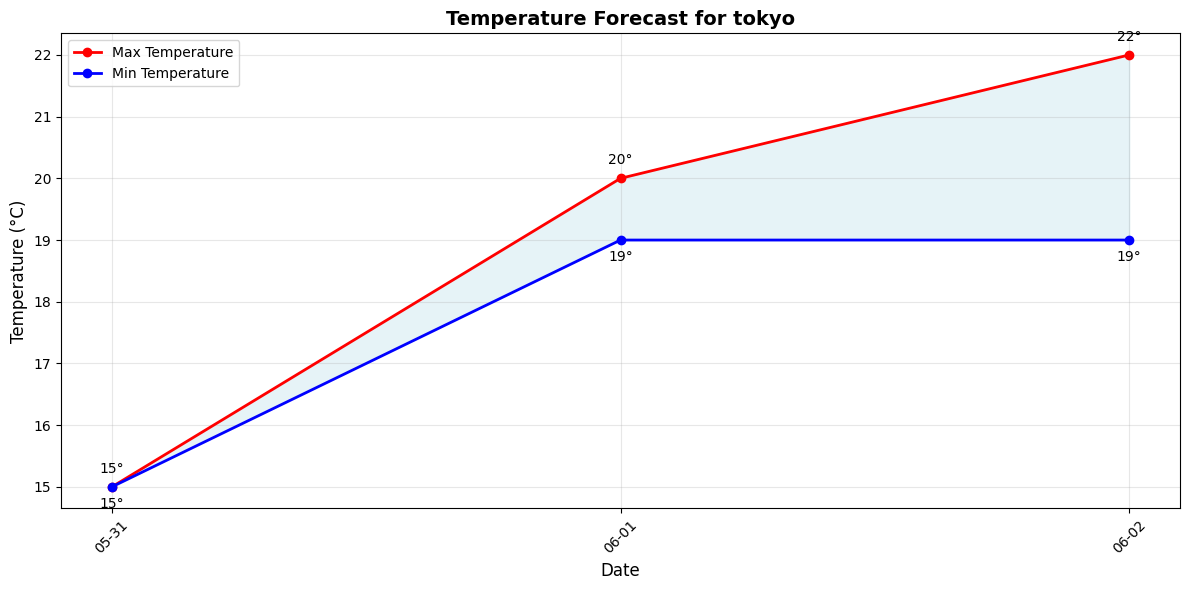

🤖 AI: 🌡️ The current temperature in tokyo is 15°C (59°F), feeling like 15°C. Tomorrow's high will be 20°C with a low of 19°C.


In [ ]:
def main():
    """Main function with menu system"""
    print("=== AI Chat Setup with Weather Integration ===")

    if not install_packages():
        print("Installation failed. Exiting...")
        return

    if not setup_environment():
        print("Environment setup failed. Exiting...")
        return

    if not test_connection():
        print("Connection test failed. Check your settings.")
        return

    # Main menu loop
    while True:
        choice = display_menu()

        if choice == 1:
            # Chat Mode Only
            continue_loop = chat_only_mode()
            if not continue_loop:
                break

        elif choice == 2:
            # Weather Data Only
            continue_loop = weather_data_only_mode()
            if not continue_loop:
                break

        elif choice == 3:
            # Weather Visualization Only
            continue_loop = weather_visualization_only_mode()
            if not continue_loop:
                break

        elif choice == 4:
            # Full Integration
            continue_loop = full_integration_mode()
            if not continue_loop:
                break

        elif choice == 5:
            # Exit
            print("👋 Thank you for using the AI chatbot!")
            break

if __name__ == "__main__":
    main()